In [4]:
%cd ../

In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = False
import random
import numpy as np
from GMN.configure import *
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

av = Namespace(   want_cuda                    = True,
                  has_cuda                   = torch.cuda.is_available(),
                  DIR_PATH                   =".",
                  special_mode               = "",
                  DATASET_NAME               = "ptc_mm_500qgrlarge",
                  FEAT_TYPE                  = "One",
                  filters_1                  = 10,
                  filters_2                  = 10,
                  filters_3                  = 10,
                  transform_dim              = 16,
                  bottle_neck_neurons        = 10,
                  tensor_neurons             = 10,               
                  dropout                    = 0,
                  BATCH_SIZE                 =8000,
                  n_layers                   = 3,
                  conv_type                  = "SAGE",
                  method_type                = "order",
                  skip                       = "learnable",
                  neuromatch_hidden_dim      = 10,
                  post_mp_dim                = 64,
                  bins                       = 16,
                  histogram                  = False,
                  GMN_NPROPLAYERS            = 5,
                  GOSSIP_TEMP                = 1.0,
                  CONV                       = "GCN",
                  gt_mode                    = "qap",
                  mcs_mode                   = "edge",
                  training_mode              = "mse",
                  MARGIN                     = 0.1,
                  NOISE_FACTOR               = 0,
                  TEMP                       = 0.1,
                  NITER                      = 20,
               TASK = ""
              )

def load_config(): 
  # Print configure
  config = get_default_config()
  config['encoder'] ['node_hidden_sizes'] = [av.filters_3]#[10]
  config['encoder'] ['node_feature_dim'] = 1
  config['encoder'] ['edge_feature_dim'] = 1
  config['aggregator'] ['node_hidden_sizes'] = [av.filters_3]#[10]
  config['aggregator'] ['graph_transform_sizes'] = [av.filters_3]#[10]
  config['aggregator'] ['input_size'] = [av.filters_3]#[10]
  config['graph_matching_net'] ['node_state_dim'] = av.filters_3#10
  #config['graph_matching_net'] ['n_prop_layers'] = av.GMN_NPROPLAYERS
  config['graph_matching_net'] ['edge_hidden_sizes'] = [2*av.filters_3]#[20]
  config['graph_matching_net'] ['node_hidden_sizes'] = [av.filters_3]#[10]
  config['graph_matching_net'] ['n_prop_layers'] = 5
  config['graph_embedding_net'] ['node_state_dim'] = av.filters_3#10
  #config['graph_embedding_net'] ['n_prop_layers'] = av.GMN_NPROPLAYERS
  config['graph_embedding_net'] ['edge_hidden_sizes'] = [2*av.filters_3]#[20]
  config['graph_embedding_net'] ['node_hidden_sizes'] = [av.filters_3]#[10]    
  config['graph_embedding_net'] ['n_prop_layers'] = 5

  #logger.info("av gmn_prop_param")
  #logger.info(av.GMN_NPROPLAYERS) 
  #logger.info("config param")
  #logger.info(config['graph_embedding_net'] ['n_prop_layers'] )
  config['graph_embedding_net'] ['n_prop_layers'] = av.GMN_NPROPLAYERS
  config['graph_matching_net'] ['n_prop_layers'] = av.GMN_NPROPLAYERS
  #logger.info("config param")
  #logger.info(config['graph_embedding_net'] ['n_prop_layers'] )

  config['training']['batch_size']  = av.BATCH_SIZE
  config['training']['margin']  = av.MARGIN
  config['evaluation']['batch_size']  = av.BATCH_SIZE
  config['model_type']  = "embedding"
  config['graphsim'] = {} 
  config['graphsim']['conv_kernel_size'] = [10,4,2]
  config['graphsim']['linear_size'] = [24, 16]
  config['graphsim']['gcn_size'] = [10,10,10]
  config['graphsim']['conv_pool_size'] = [3,3,2]
  config['graphsim']['conv_out_channels'] = [2,4,8]
  config['graphsim']['dropout'] = av.dropout 

  # Set random seeds
  seed = config['seed']
  random.seed(seed)
  np.random.seed(seed + 1)
  torch.manual_seed(seed + 2)
  torch.backends.cudnn.deterministic = False
  return config

 
config = load_config()

seed = config['seed']
random.seed(seed)
np.random.seed(seed + 1)
torch.manual_seed(seed + 2)
torch.backends.cudnn.deterministic = False
   

In [3]:
from subgraph.earlystopping import EarlyStoppingModule
from mcs.models import *
from mcs.evaluate import *
es = EarlyStoppingModule(av,50)
device = "cuda" if av.has_cuda and av.want_cuda else "cpu"
import matplotlib.pyplot as plt


Using backend: pytorch


In [4]:
def fetch_best_model(task,dataset):
    config = load_config()
    av.TASK = task
    av.DATASET_NAME = dataset 
    av.dataset_stats = pickle.load(open('Datasets/mcs/splits/stats/%s_dataset_stats.pkl' % av.DATASET_NAME, "rb"))

    #if "qap" in av.gt_mode:
    av.TASK = av.TASK + "_gt_mode_" + av.gt_mode
    #if av.training_mode == "rank":
    av.TASK = av.TASK + "_trMode_" + av.training_mode
    if av.FEAT_TYPE == "Adjrow" or  av.FEAT_TYPE == "Adjrow1" or av.FEAT_TYPE == "AdjOnehot": 
        av.TASK = av.TASK + "_" + av.FEAT_TYPE
    if av.CONV != "GCN": 
        av.TASK = av.TASK + "_" + av.CONV
    

    if av.TASK.startswith("ISONET_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = ISONET_for_mcs(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"  
    elif av.TASK.startswith("ISONET_baseline"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = ISONET_baseline(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"  
    elif av.TASK.startswith("T3_ISONET_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = T3_ISONET_for_mcs(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("AllLayersPos_T3_ISONET_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = AllLayersPos_T3_ISONET_for_mcs(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("AsymCrossSinkhorn_T3_ISONET_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = AsymCrossSinkhorn_T3_ISONET_for_mcs(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("AsymCrossSinkhorn_AllLayersPos_T3_ISONET_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = AsymCrossSinkhorn_AllLayersPos_T3_ISONET_for_mcs(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("T3_GMN_embed"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = T3_GMN_embed(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("T3_GMN_match"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = T3_GMN_match(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("T5_GMN_embed_nomin"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = T5_GMN_embed_nomin(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("T5_GMN_match_nomin"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = T5_GMN_match_nomin(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("IsoNetVar29ForMcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = IsoNetVar29ForMcs(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("Try2Abaltion_NoThresh_IsoNetGossipVar29ForMcs_GossipVector"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = Try2Abaltion_NoThresh_IsoNetGossipVar29ForMcs_GossipVector(av,config,1).to(device)
        test_data.data_type = "gmn"
        val_data.data_type = "gmn"
    elif av.TASK.startswith("SimGNN_for_mcs") :
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = SimGNN_for_mcs(av,1).to(device)
        test_data.data_type = "pyg"
        val_data.data_type = "pyg"
    elif av.TASK.startswith("GraphSim_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = GraphSim_for_mcs(av,config,1).to(device)
        test_data.data_type = "pyg"
        val_data.data_type = "pyg"
    elif av.TASK.startswith("GOTSim_for_mcs"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_nodes'] 
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")
        model = GOTSim_for_mcs(av,config,1).to(device)
        test_data.data_type = "pyg"
        val_data.data_type = "pyg" 
    elif av.TASK.startswith("NeuroMatch"):
        av.MAX_SET_SIZE = av.dataset_stats['max_num_edges']
        test_data = McsData(av,mode="test")
        val_data = McsData(av,mode="val")    
        model = NeuroMatch(1,av.neuromatch_hidden_dim,av).to(device) 
        test_data.data_type = "pyg" 
        val_data.data_type = "pyg" 

    else:
        raise NotImplementedError()    
    model.eval()
    checkpoint = es.load_best_model()
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, test_data


In [5]:
   
#QAP,GOSSIP,GLASGOW - MSE,RANK -> 6 TABLES
task_dict = {} 
all_results = {} 
for algo in ["IsoNetGossip_node_EdgeScore_LC1_temp5e-1",\
             "Try1_IsoNetGossip_node_EdgeScore_LC1_temp1e+0",\
             "Try2_IsoNetGossip_node_EdgeScore_LC1_temp1e+0",\
             "Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned",\
             'GMN_embed','GMN_match','IsoNet_node','IsoNet_edge',"IsoNet_node_EdgeScore",\
             "SimGNN","GraphSim","GOTSim","NeuroMatch",\
            "AllLayers_IsoNet_node","AllLayersPos_IsoNet_node","CrossSinkhorn_T3_ISONET_for_mcs",\
             "CrossSinkhorn_AllLayers_T3_ISONET_for_mcs","IsoNet_baseline",\
             "CrossSinkhorn_AllLayersPos_T3_ISONET_for_mcs","AsymCrossSinkhorn_T3_ISONET_for_mcs",\
             "AsymCrossSinkhorn_AllLayers_T3_ISONET_for_mcs",\
             "ConvexKronProd_IsoNet_9e-1","ConvexKronProd_IsoNet_7e-1",\
             "ConvexKronProd_IsoNet_5e-1","AsymCrossSinkhorn_ConvexKronProd_IsoNet_9e-1",\
             "AsymCrossSinkhorn_ConvexKronProd_IsoNet_7e-1","AsymCrossSinkhorn_ConvexKronProd_IsoNet_5e-1",\
             "AsymCrossSinkhorn_AllLayersPos_T3_ISONET_for_mcs",'GMN_embed_nomin','GMN_match_nomin']: 
    task_dict[algo] = {}
    all_results[algo] = {}
    for gt_mode in ['qap','gossip_qap']:#,'glasgow']:
        task_dict[algo][gt_mode] = {}
        all_results[algo][gt_mode] = {}
        for training_mode in ['mse']:
            task_dict[algo][gt_mode][training_mode] = {}
            all_results[algo][gt_mode][training_mode] = {}


for dataset in ['ptc_mm_500qgrlarge','ptc_mr_500qgrlarge','ptc_fm_500qgrlarge',\
                            'ptc_fr_500qgrlarge','msrc_21_500qgrlarge',\
                            'dd_500qgrlarge', 'cox2_500qgrlarge']:
    for gt_mode in ['qap','gossip_qap']:#,'glasgow']:
        task_dict['GMN_embed'][gt_mode]['mse'][dataset] = "T3_GMN_embed_newrun1_FlagOff"
        task_dict['GMN_match'][gt_mode]['mse'][dataset] = "T3_GMN_match_newrun1_FlagOff"
        task_dict['GMN_embed_nomin'][gt_mode]['mse'][dataset] = "T5_GMN_embed_nomin_newrun1_FlagOff"
        task_dict['GMN_match_nomin'][gt_mode]['mse'][dataset] = "T5_GMN_match_nomin_newrun1_FlagOff"
        task_dict['SimGNN'][gt_mode]['mse'][dataset] = "SimGNN_for_mcs_newrun1_FlagOff"
        task_dict['GraphSim'][gt_mode]['mse'][dataset] = "GraphSim_for_mcs_newrun1_FlagOff"
        task_dict['GOTSim'][gt_mode]['mse'][dataset] = "GOTSim_for_mcs_newrun1_FlagOff"
        task_dict['NeuroMatch'][gt_mode]['mse'][dataset] = "NeuroMatch_for_mcs_newrun1_FlagOff"
        task_dict['IsoNet_node'][gt_mode]['mse'][dataset] = "T3_ISONET_for_mcs_newrun1_FlagOff_nodeEmb_td16_lr1e-3_noise0"
        task_dict['AllLayersPos_IsoNet_node'][gt_mode]['mse'][dataset] = "AllLayersPos_T3_ISONET_for_mcs_newrun1_FlagOff_nodeEmb_td16_lr1e-3_noise0"
        task_dict['AsymCrossSinkhorn_T3_ISONET_for_mcs'][gt_mode]['mse'][dataset] = "AsymCrossSinkhorn_T3_ISONET_for_mcs_newrun1_FlagOff_nodeEmb_td16_lr1e-3_noise0"
        task_dict['AsymCrossSinkhorn_AllLayersPos_T3_ISONET_for_mcs'][gt_mode]['mse'][dataset] = "AsymCrossSinkhorn_AllLayersPos_T3_ISONET_for_mcs_newrun1_FlagOff_nodeEmb_td16_lr1e-3_noise0"
        task_dict['IsoNet_edge'][gt_mode]['mse'][dataset] = "ISONET_for_mcs_newrun1_FlagOff_edgeEmb_td16_lr1e-3_noise0"
        task_dict['IsoNet_baseline'][gt_mode]['mse'][dataset] = "ISONET_baseline_newrun1_FlagOff_edgeEmb_td16_lr1e-3_noise0"
        task_dict['IsoNet_node_EdgeScore'][gt_mode]['mse'][dataset] = "IsoNetVar29ForMcs_newrun1_FlagOff_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
        task_dict['IsoNetGossip_node_EdgeScore_LC1_temp5e-1'][gt_mode]['mse'][dataset] = "IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp5e-1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
        task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_temp1e+0'][gt_mode]['mse'][dataset] = "Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp1e+0_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"

task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['ptc_mm_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp7e-1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['ptc_mr_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp1e-1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['ptc_fm_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp8e-1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['ptc_fr_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp14e-1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['msrc_21_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp1e+0_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['dd_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp1e+1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"
task_dict['Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned'][gt_mode]['mse']['cox2_500qgrlarge'] = \
"Try2_IsoNetGossipVar29ForMcs_GossipVectorLRLThreshold_newrun1_FlagOff_temp11e-1_nodeEmbEdgeScoreAdjMask_td16_lr1e-3_noise0"

     
for dataset in ['ptc_mm_500qgrlarge','ptc_mr_500qgrlarge','ptc_fm_500qgrlarge','ptc_fr_500qgrlarge']:
    for gt_mode in ['qap','gossip_qap']:#,'glasgow']:
        task_dict['GMN_match'][gt_mode]['mse'][dataset] = "T3_GMN_match_newrun1"
        task_dict['SimGNN'][gt_mode]['mse'][dataset] = "SimGNN_for_mcs_newrun1"
        task_dict['GraphSim'][gt_mode]['mse'][dataset] = "GraphSim_for_mcs_newrun1"
        task_dict['GOTSim'][gt_mode]['mse'][dataset] = "GOTSim_for_mcs_newrun1"
        task_dict['NeuroMatch'][gt_mode]['mse'][dataset] = "NeuroMatch_for_mcs_newrun1"
    

In [6]:
#ALIGNMENT PROBING TOOLS

def count_unique_elem(itlist):
  for k in set(itlist):
    print(k, sum(np.array(itlist) == k))
    
def get_percent_exact_matches(ground_truth,pred_mcs):
    difflist = [a-b for (a,b) in zip(ground_truth,pred_mcs)]
    return ((sum(np.array(difflist) == 0)*100)/len(difflist))

def bucketize_list(input_list, thresholds):
    """
        input_list = [(9.0, 5.0), (10.0, 8.0), (11.0, 4.0)...]
        thresholds = [0,9.1,10.1,11.1,14.1]
    """
    op_list_of_lists = []
    assert(len(thresholds)>1)
    for idx in range(1,len(thresholds)): 
        filter_list = [x[1] for x in input_list if ((x[0]<thresholds[idx]) and (x[0]>thresholds[idx-1]))]
        op_list_of_lists.append(filter_list)
    assert(sum([len(x) for x in op_list_of_lists]) == len(input_list))
    return op_list_of_lists
def get_range(input_list): 
    a,b = zip(*input_list)
    return min(b), max(b)


def plot_hist(input_list, thresholds):
    bucket_list = bucketize_list(input_list, thresholds)
    min_r, max_r = get_range(input_list)

    nplots = len(bucket_list)
    plt.rcParams["figure.figsize"] = (10,nplots*5)
    plt.rcParams.update({'font.size': 14})
    for i in range(1,nplots+1):

        #tick_locs = np.arange(-20,1,2)
        plt.subplot(nplots, 1, i) # row 1, col 2 index 1
        display_list = bucket_list[i-1]

        countspos, binspos, barspos = plt.hist(display_list,range=[min_r, max_r],\
                                               weights=np.ones(len(display_list)) / len(display_list),\
                                               ec='black')
        #pos_toplabels = ["{:.3f}".format(x) for x in countspos/sum(countspos)]
        pos_toplabels = ["{:.3f}".format(x) for x in countspos]

        # a,b = plt.xticks()
        # print(a,binspos)
        tick_locs =binspos
        for x,y,z in zip(tick_locs,countspos,pos_toplabels):
            #plt.text(x+0.01,y+20, z)
            plt.text(x+0.01,y+0.01, z)


        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,y1,y2*1.1))
        plt.ylabel('no of (q,c) pairs', fontsize=18)
        plt.text(tick_locs[0]-0.02,max(countspos), str(thresholds[i-1]) + "-" + str(thresholds[i]), size=15, color='purple')

    plt.figtext(0.2, 0.9, algo + "-" + dataset)

    plt.show()  

def eval_node_alignment(av,bestM, sampler):
    """
      bestM: usually best validation model is to be passed here for diagnostics
      sampler: evaluation data to be passed here. 
    """
    bestM.diagnostic_mode = True

    q_graphs = list(range(len(sampler.query_graphs)))    
    if av.gt_mode == "qap":
        list_all = sampler.list_all_qap_mcs
    elif av.gt_mode == "gossip_qap":
        list_all = sampler.list_all_gossip_qap_mcs
    else: 
        raise NotImplementedError()
        

    n_batches = sampler.create_batches(shuffle=False,input_list=list_all)
    plans = []  
    aq = []
    ac = []
    qsz = [] 
    csz = []
    targets = []
    for i in range(n_batches):
        batch_data,batch_data_sizes,target,batch_adj = sampler.fetch_batched_data_by_id(i)
        plans.append( bestM(batch_data,batch_data_sizes,batch_adj).detach())
        targets.append(target)
        a, b = zip(*batch_adj)
        aq.append(torch.stack(a))
        ac.append(torch.stack(b))
        a,b = zip(*batch_data_sizes)
        qsz.append(cudavar(av,torch.tensor(a)))
        csz.append(cudavar(av,torch.tensor(b)))
    all_plans = torch.cat(plans,dim=0) 
    all_targets = torch.cat(targets,dim=0)
    all_aq  = torch.cat(aq)
    all_ac  = torch.cat(ac)  
    all_qsz = torch.cat(qsz)
    all_csz = torch.cat(csz)
    all_hard_plans = []
    for p in all_plans:
        soft_plan = p.detach().cpu()
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(-soft_plan)
        #Imp: Subtle bug introduced if following line goes out of the for loop (due to backspace)
        all_hard_plans.append(torch.eye(av.MAX_SET_SIZE)[col_ind])
        
    all_hard_plans = cudavar(av,torch.stack(all_hard_plans))
    all_qedge_sz = torch.sum(all_aq,dim=(1,2))/2
    all_cedge_sz = torch.sum(all_ac,dim=(1,2))/2

    #Divide by 2 since each edge is counted twice in undirected graphs
    hingeScore1 = torch.sum(torch.min(all_aq, all_hard_plans@all_ac@all_hard_plans.permute(0,2,1)),\
                      dim=(1,2))/2
    hingeScore2 = torch.div(hingeScore1,torch.mul(all_qsz,all_csz))
    hingeScore3 = torch.div(hingeScore1,all_qedge_sz)/2


    all_hs1 = hingeScore1.tolist()
    all_hs2 = hingeScore2.tolist()
    all_hs3 = hingeScore3.tolist()

    # Reverting back to original state     
    bestM.diagnostic_mode = False
    return all_targets.tolist(),all_hs1, all_hs2, all_hs3


def reshape_to_group_by_graph(input_tensor,Bsz):
    """
        Bsz : Batch Size
        Input: [q1-c1 prop1,..qBatch-cBsz prop1,\
                q1-c1 prop2,..qBatch-cBsz prop2,\
                q1-c1 prop3,..qBatch-cBsz prop3,\
                q1-c1 prop4,..qBatch-cBsz prop4,\
                q1-c1 prop5,..qBatch-cBsz prop5]
        Output : [q1-c1 prop1,q1-c1 prop2,q1-c1 prop3,q1-c1 prop4,q1-c1 prop5,\
                  q2-c2 prop1,q2-c2 prop2,q2-c2 prop3,q2-c2 prop4,q2-c2 prop5,\
                  ......,\
                  qBsz-cBsz prop1,qBsz-cBsz prop2,...,qBsz-cBsz prop5]
    """
    tmp = input_tensor.view(-1, av.BATCH_SIZE,*input_tensor.shape[1:])
    return tmp.permute(1,0,2,3).reshape(-1,*input_tensor.shape[1:])

def eval_AllLayerPos_node_alignment_Avg(av,bestM, sampler):
    """
      bestM: usually best validation model is to be passed here for diagnostics
      sampler: evaluation data to be passed here. 
    """
    bestM.diagnostic_mode = True

    q_graphs = list(range(len(sampler.query_graphs)))    
    if av.gt_mode == "qap":
        list_all = sampler.list_all_qap_mcs
    elif av.gt_mode == "gossip_qap":
        list_all = sampler.list_all_gossip_qap_mcs
    else: 
        raise NotImplementedError()
        

    n_batches = sampler.create_batches(shuffle=False,input_list=list_all)
    num_layers = bestM.config['graph_embedding_net'] ['n_prop_layers']
    plans = []  
    aq = []
    ac = []
    qsz = [] 
    csz = []
    targets = []
    for i in range(n_batches):
        batch_data,batch_data_sizes,target,batch_adj = sampler.fetch_batched_data_by_id(i)
        #print("1 ",torch.cuda.memory_reserved(0)/(1024*1024*1024), "GB")
        batch_sz = len(target)
        plans.append( reshape_to_group_by_graph(bestM(batch_data,batch_data_sizes,batch_adj).detach(),batch_sz))
        #print("2 ",torch.cuda.memory_reserved(0)/(1024*1024*1024), "GB")
        targets.append(target)
        a, b = zip(*batch_adj)
        #NOTE:below asserts True
        #(reshape_to_group_by_graph(aq[0].repeat(5,1,1),len(target)) == \
        #torch.repeat_interleave(aq[0],5,dim=0)).all()
        aq.append(torch.repeat_interleave(torch.stack(a),num_layers,dim=0))
        ac.append(torch.repeat_interleave(torch.stack(b),num_layers,dim=0))
        #print("3 ",torch.cuda.memory_reserved(0)/(1024*1024*1024), "GB")
        a,b = zip(*batch_data_sizes)
        qsz.append(torch.repeat_interleave(cudavar(av,torch.tensor(a)),num_layers,dim=0))
        csz.append(torch.repeat_interleave(cudavar(av,torch.tensor(b)),num_layers,dim=0))
        #print("4 ",torch.cuda.memory_reserved(0)/(1024*1024*1024), "GB")
    all_plans = torch.cat(plans,dim=0) 
    all_targets = torch.cat(targets,dim=0)
    all_aq  = torch.cat(aq)
    all_ac  = torch.cat(ac)  
    all_qsz = torch.cat(qsz)
    all_csz = torch.cat(csz)
    all_hard_plans = []
    for p in all_plans:
        soft_plan = p.detach().cpu()
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(-soft_plan)
        #Imp: Subtle bug introduced if following line goes out of the for loop (due to backspace)
        all_hard_plans.append(torch.eye(av.MAX_SET_SIZE)[col_ind])
        
    all_hard_plans = cudavar(av,torch.stack(all_hard_plans))
    all_qedge_sz = torch.sum(all_aq,dim=(1,2))/2
    all_cedge_sz = torch.sum(all_ac,dim=(1,2))/2

    #Divide by 2 since each edge is counted twice in undirected graphs
    hingeScore1 = torch.sum(torch.min(all_aq, all_hard_plans@all_ac@all_hard_plans.permute(0,2,1)),\
                      dim=(1,2))/2
    hingeScore2 = torch.div(hingeScore1,torch.mul(all_qsz,all_csz))
    hingeScore3 = torch.div(hingeScore1,all_qedge_sz)/2

    
    all_hs1 = hingeScore1.view(-1,num_layers).mean(dim=-1).tolist()
    all_hs2 = hingeScore2.view(-1,num_layers).mean(dim=-1).tolist()
    all_hs3 = hingeScore3.view(-1,num_layers).mean(dim=-1).tolist()

    # Reverting back to original state     
    bestM.diagnostic_mode = False
    return all_targets.tolist(),all_hs1, all_hs2, all_hs3,\
            hingeScore1,hingeScore2,hingeScore3


def gossip_score_v4_batched(A):
    eps = 1
    V = A.shape[-1]
    x_0 = (torch.eye(V)).tile(A.shape[0],1,1).cuda()
    A1 = A+x_0
    x_k = x_0
    for i in range(V):
        x_k = x_k@A1
    indicator = eps - torch.nn.ReLU() (eps-x_k)   
    res = torch.max(torch.sum(indicator,dim=-1),dim=-1)[0]
    return res

def iterative_gossip(A,x_0):
    """
        A: adjacency matrix (should be square)
        x_0 : initial node values
    """
    #Note: don't use below inplace command since backprop hindered
    #A.fill_diagonal_(1)
    #Use this version instead
    A =  torch.eye(A.shape[0]).cuda() + A
    x_k = x_0 
    for i in range(A.shape[0]):
        x_k = torch.max(A.double()*x_k.double().expand(x_k.shape[0],x_k.shape[0]),axis=0)[0].unsqueeze(1)
    return x_k

def gossip_score(A):
    V = A.shape[0]
    x_0 = ((torch.arange(V)+1)*V).cuda()
    x_k = iterative_gossip(A,x_0) 
    err = torch.abs(x_k.expand(x_k.shape[0],x_k.shape[0]) \
                    -x_k.t().expand(x_k.shape[0],x_k.shape[0]) ) 
    res = torch.max(torch.sum((err==0).long(), dim=1))
    return res.item()



def eval_gossip_node_alignment(av,bestM, sampler):
    """
      bestM: usually best validation model is to be passed here for diagnostics
      sampler: evaluation data to be passed here. 
    """
    bestM.diagnostic_mode = True

    q_graphs = list(range(len(sampler.query_graphs)))    
    if av.gt_mode == "qap":
        list_all = sampler.list_all_qap_mcs
    elif av.gt_mode == "gossip_qap":
        list_all = sampler.list_all_gossip_qap_mcs
    else: 
        raise NotImplementedError()
        

    n_batches = sampler.create_batches(shuffle=False,input_list=list_all)
    plans = []  
    aq = []
    ac = []
    qsz = [] 
    csz = []
    targets = []
    for i in range(n_batches):
        batch_data,batch_data_sizes,target,batch_adj = sampler.fetch_batched_data_by_id(i)
        plans.append( bestM(batch_data,batch_data_sizes,batch_adj).detach())
        targets.append(target)
        a, b = zip(*batch_adj)
        aq.append(torch.stack(a))
        ac.append(torch.stack(b))
        a,b = zip(*batch_data_sizes)
        qsz.append(cudavar(av,torch.tensor(a)))
        csz.append(cudavar(av,torch.tensor(b)))
    all_plans = torch.cat(plans,dim=0) 
    all_targets = torch.cat(targets,dim=0)
    all_aq  = torch.cat(aq)
    all_ac  = torch.cat(ac)  
    all_qsz = torch.cat(qsz)
    all_csz = torch.cat(csz)
    all_hard_plans = []
    for p in all_plans:
        soft_plan = p.detach().cpu()
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(-soft_plan)
        #Imp: Subtle bug introduced if following line goes out of the for loop (due to backspace)
        all_hard_plans.append(torch.eye(av.MAX_SET_SIZE)[col_ind])
        
    all_hard_plans = cudavar(av,torch.stack(all_hard_plans))
    all_qedge_sz = torch.sum(all_aq,dim=(1,2))/2
    all_cedge_sz = torch.sum(all_ac,dim=(1,2))/2
    
    Abar = torch.min(all_aq, all_hard_plans@all_ac@all_hard_plans.permute(0,2,1))
    
    hingeScore1 = gossip_score_v4_batched(Abar)
#     hingeScore1 = torch.sum(torch.min(all_aq, all_hard_plans@all_ac@all_hard_plans.permute(0,2,1)),\
#                       dim=(1,2))/2
#     hingeScore2 = torch.div(hingeScore1,torch.mul(all_qsz,all_csz))
#     hingeScore3 = torch.div(hingeScore1,all_qedge_sz)/2


#     all_hs1 = hingeScore1.tolist()
#     all_hs2 = hingeScore2.tolist()
#     all_hs3 = hingeScore3.tolist()

    # Reverting back to original state     
    bestM.diagnostic_mode = False
#     return all_targets.tolist(),all_hs1, all_hs2, all_hs3
    return all_targets.tolist(),hingeScore1.tolist()




In [11]:
align_result_dict = {}
algo = "AsymCrossSinkhorn_T3_ISONET_for_mcs"
align_result_dict[algo] ={}
av.gt_mode = "gossip_qap"
align_result_dict[algo][av.gt_mode] ={}
av.training_mode = "mse"

#for dataset in ['ptc_mm_500qgrlarge','ptc_mr_500qgrlarge','ptc_fm_500qgrlarge',\
#                'ptc_fr_500qgrlarge','msrc_21_500qgrlarge', 'cox2_500qgrlarge']:
for dataset in ['ptc_fr_500qgrlarge']:
    av.DATASET_NAME = dataset

    av.TASK = task_dict[algo][av.gt_mode][av.training_mode][dataset]
    bestM,test_data = fetch_best_model(av.TASK,dataset)
    s = time.time()
    align_result_dict[algo][av.gt_mode][dataset] = eval_gossip_node_alignment(av,bestM,test_data)
    print(time.time()-s)

loading test query graphs from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_enhanced_query_subgraphs.pkl
loading test mcs info from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_rel_mccreesh_mcs.pkl
loading test qap mcs info from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_rel_qap_mcs.pkl
loading test gossip qap mcs info from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_rel_gossip_qap_mcs.pkl
loading corpus graphs from ./Datasets/mcs/splits/ptc_fr_500qgrlarge80k_corpus_subgraphs.pkl
loading val query graphs from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_enhanced_query_subgraphs.pkl
loading val mcs info from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_rel_mccreesh_mcs.pkl
loading val qap mcs info from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_rel_qap_mcs.pkl
loading val gossip qap mcs info from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_rel_gossip_qap_mcs.pkl
loading corpus graphs from ./Datasets/mcs/splits/ptc_fr_

In [22]:
def fetch_data(source, batch):
    """
      source : train_data/test_data/val_data
      batch  : list of ((qid,cid),label)
               sometimes there may be score instead of label.
               Doesn't matter since unused
    """
    gq = [source.query_graphs[x[0][0]] for x in batch]
    gq_adj = [source.query_graph_adj_list[x[0][0]] for x in batch]
    gq_size = [source.query_graph_size_list[x[0][0]] for x in batch]

    gc = [source.corpus_graphs[x[0][1]] for x in batch]
    gc_adj = [source.corpus_graph_adj_list[x[0][1]] for x in batch]
    gc_size = [source.corpus_graph_size_list[x[0][1]] for x in batch]
    all_data =  source._pack_batch(zip(gq,gc))
    all_sizes = list(zip(gq_size,gc_size))
    all_adj = list(zip(gq_adj,gc_adj))
    return all_data, all_sizes, all_adj 

def get_nodes_gossip_score_v4_batched(test_data, data_pair, col_ind):
    q_adj = test_data.query_graph_adj_list[data_pair[0][0]].unsqueeze(0)
    c_adj = test_data.corpus_graph_adj_list[data_pair[0][1]].unsqueeze(0)
    hard_plan = (torch.eye(av.MAX_SET_SIZE).cuda()[col_ind]).unsqueeze(0)
    Abar = torch.min(q_adj, hard_plan@c_adj@hard_plan.permute(0,2,1))
    A =Abar
    eps = 1
    V = A.shape[-1]
    x_0 = (torch.eye(V)).tile(A.shape[0],1,1).cuda()
    A1 = A+x_0
    x_k = x_0
    for i in range(V):
        x_k = x_k@A1
    indicator = eps - torch.nn.ReLU() (eps-x_k)   
    #res = torch.max(torch.sum(indicator,dim=-1),dim=-1)[0]
    res = torch.sum(indicator,dim=-1)
    
    val = res.squeeze()
    isMax = val == max(val)
    return isMax

def plot_gossip_gr(test_data, data_pair,col_ind,fname=""):
    q_G = test_data.query_graphs[data_pair[0][0]]
    c_G = test_data.corpus_graphs[data_pair[0][1]]
    isMax = get_nodes_gossip_score_v4_batched(test_data, data_pair, col_ind)

    fig, ((qPlot, cPlot)) = plt.subplots(1, 2, figsize=(25,14))

#     fig, ax = plt.subplots(figsize=(15,14))
    q_pos = nx.kamada_kawai_layout(q_G)
    node_color_list = ["#DC143C", "#FF1493", "#C71585", "#FF8C00", "#663399", "#9400D3", "#4B0082", "#3CB371", "#228B22", "#0000FF", "#A52A2A", "#DEB887", "#DAA520", "#BDB76B", "#FFD700"]
    n_q = len(q_G.nodes())
    q_n_labels={node:str(idx) for idx, node in enumerate(q_G.nodes())}
    
    q_edge_cmap = []
    for (a,b) in q_G.edges():
        if isMax[a] and isMax[b] and (col_ind[a],col_ind[b]) in c_G.edges():
            q_edge_cmap.append("#E2F04A")
        else:
            q_edge_cmap.append("#D3D3D3")

        
    q_options = {
        "node_color": [node_color_list[i] for i in range(len(q_G.nodes()))],
        "edgecolors": "black",
        #"edge_color": "#2E3E70",
        "edge_color": q_edge_cmap, #"#D3D3D3",
        "node_size": 4000,
        "width": 20,
        #"edge_labels": e_labels,
        #"edge_cmap": plt.cm.tab20c,
        #"edge_cmap": q_cmap,
        "alpha": 1,
        "linewidths": 3,
        "with_labels": False,
    }


    c_pos = nx.kamada_kawai_layout(c_G)
    n_c = len(c_G.nodes())
    c_n_labels={node:str(idx) for idx, node in enumerate(c_G.nodes())}
    c_node_map = {b:a for (a,b) in enumerate(col_ind)}
    
    c_edge_cmap = []
    for (a,b) in c_G.edges():
        if isMax[c_node_map[a]] and isMax[c_node_map[b]] and  (c_node_map[a],c_node_map[b]) in q_G.edges():
            c_edge_cmap.append("#E2F04A")
        else:
            c_edge_cmap.append("#D3D3D3")
            
    c_options = {
        "node_color": [node_color_list[c_node_map[x]] for x in range(len(c_G.nodes()))],
        #"node_color": [node_color_list[x] for x in col_ind[:n_c]],
        "edgecolors": "black",
        #"edge_color": "#2E3E70",
        "edge_color": c_edge_cmap,#"#D3D3D3",
        "node_size": 4000,
        "width": 20,
        #"edge_labels": e_labels,
        #"edge_cmap": plt.cm.tab20c,
        #"edge_cmap": q_cmap,
        "alpha": 1,
        "linewidths": 3,
        "with_labels": False,
    }
    
    nx.draw(q_G, q_pos, ax=qPlot, **q_options)
    nx.draw(c_G, c_pos, ax=cPlot, **c_options)
    plt.box(on=True)
    if fname is not "":
        file = fname
    else:
        file = "interpretebility_qualitative_gossip"+".pdf"
    plt.savefig(file, bbox_inches='tight') 

<>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_8366/1378122362.py:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if fname is not "":


In [12]:
list_all = align_result_dict[algo][av.gt_mode][av.DATASET_NAME][1]
max_idx= np.argsort(list_all)[::-1]
for idx in max_idx[:200]:
    data_pair = test_data.list_all_gossip_qap_mcs[idx]
    qnode = len(test_data.query_graphs[data_pair[0][0]].nodes())
    cnode = len(test_data.corpus_graphs[data_pair[0][1]].nodes())
    mcs = data_pair[1]
    if (mcs<qnode) and (mcs<cnode):
        print(idx, qnode, cnode, mcs, list_all[idx])

23919 12 12 11 11.0
3586 12 13 11 11.0
20675 12 12 11 11.0
3436 12 15 11 11.0
41774 11 12 10 10.0
23819 12 13 11 10.0
76167 12 12 10 10.0
13264 12 12 11 10.0
67421 11 12 10 10.0
76201 12 12 10 10.0
23838 12 12 11 10.0
12916 12 13 11 10.0
67319 11 12 10 10.0
3686 12 13 11 10.0
13062 12 13 11 10.0
49589 12 12 11 10.0
23961 12 12 11 10.0
23948 12 13 11 10.0
48830 12 12 11 10.0
51824 11 14 10 10.0
13306 12 12 11 10.0
23326 12 12 11 10.0
23347 12 12 11 9.0
38271 12 13 9 9.0
22852 11 12 10 9.0
13572 12 13 11 9.0
13097 12 12 11 9.0
35655 11 12 10 9.0
13138 12 15 11 9.0
25442 12 13 11 9.0


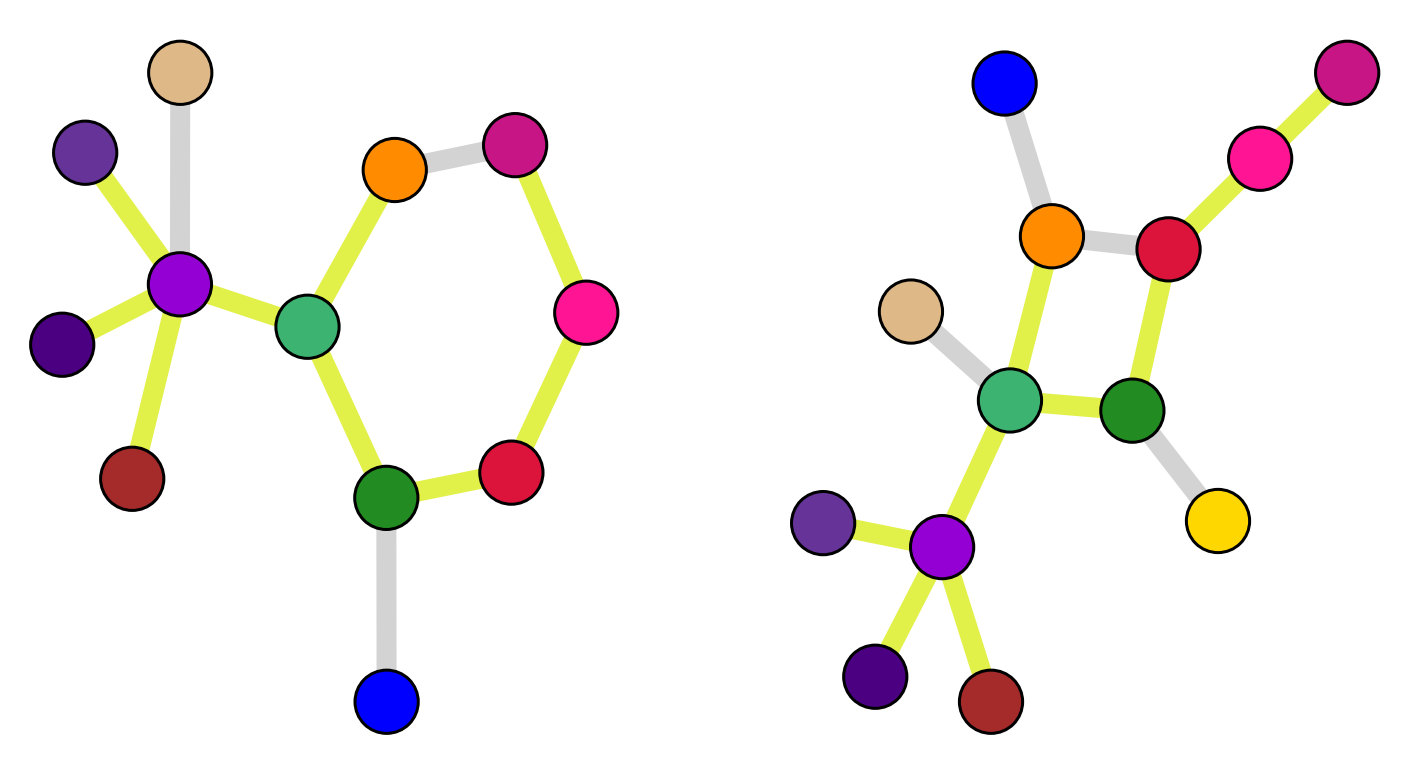

In [23]:
# algo = "AsymCrossSinkhorn_T3_ISONET_for_mcs"
# av.gt_mode = "gossip_qap"
# av.training_mode = "mse"
# av.DATASET_NAME = "ptc_fr_500qgrlarge"
# av.TASK = task_dict[algo][av.gt_mode][av.training_mode][dataset]
# bestM,test_data = fetch_best_model(av.TASK,dataset)

data_pair = test_data.list_all_gossip_qap_mcs[3586]#39947
q_G = test_data.query_graphs[data_pair[0][0]]
c_G = test_data.corpus_graphs[data_pair[0][1]]
bestM.diagnostic_mode = True
alignment = bestM(*fetch_data(test_data,[data_pair]))
row_ind, col_ind = scipy.optimize.linear_sum_assignment(-alignment.squeeze().detach().cpu())
plot_gossip_gr(test_data, data_pair,col_ind,"xmcs_good_fr.pdf")

In [14]:
algo = "Try2_IsoNetGossip_node_EdgeScore_LC1_tempTuned"
av.gt_mode = "gossip_qap"
av.GOSSIP_TEMP = 1.4
av.training_mode = "mse"
av.DATASET_NAME = "ptc_fr_500qgrlarge"
av.TASK = task_dict[algo][av.gt_mode][av.training_mode][av.DATASET_NAME]
bestM1,test_data1 = fetch_best_model(av.TASK,dataset)
align_data = eval_gossip_node_alignment(av,bestM1,test_data1)

loading test query graphs from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_enhanced_query_subgraphs.pkl
loading test mcs info from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_rel_mccreesh_mcs.pkl
loading test qap mcs info from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_rel_qap_mcs.pkl
loading test gossip qap mcs info from ./Datasets/mcs/splits/test/test_ptc_fr_500qgrlarge80k_rel_gossip_qap_mcs.pkl
loading corpus graphs from ./Datasets/mcs/splits/ptc_fr_500qgrlarge80k_corpus_subgraphs.pkl
loading val query graphs from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_enhanced_query_subgraphs.pkl
loading val mcs info from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_rel_mccreesh_mcs.pkl
loading val qap mcs info from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_rel_qap_mcs.pkl
loading val gossip qap mcs info from ./Datasets/mcs/splits/val/val_ptc_fr_500qgrlarge80k_rel_gossip_qap_mcs.pkl
loading corpus graphs from ./Datasets/mcs/splits/ptc_fr_

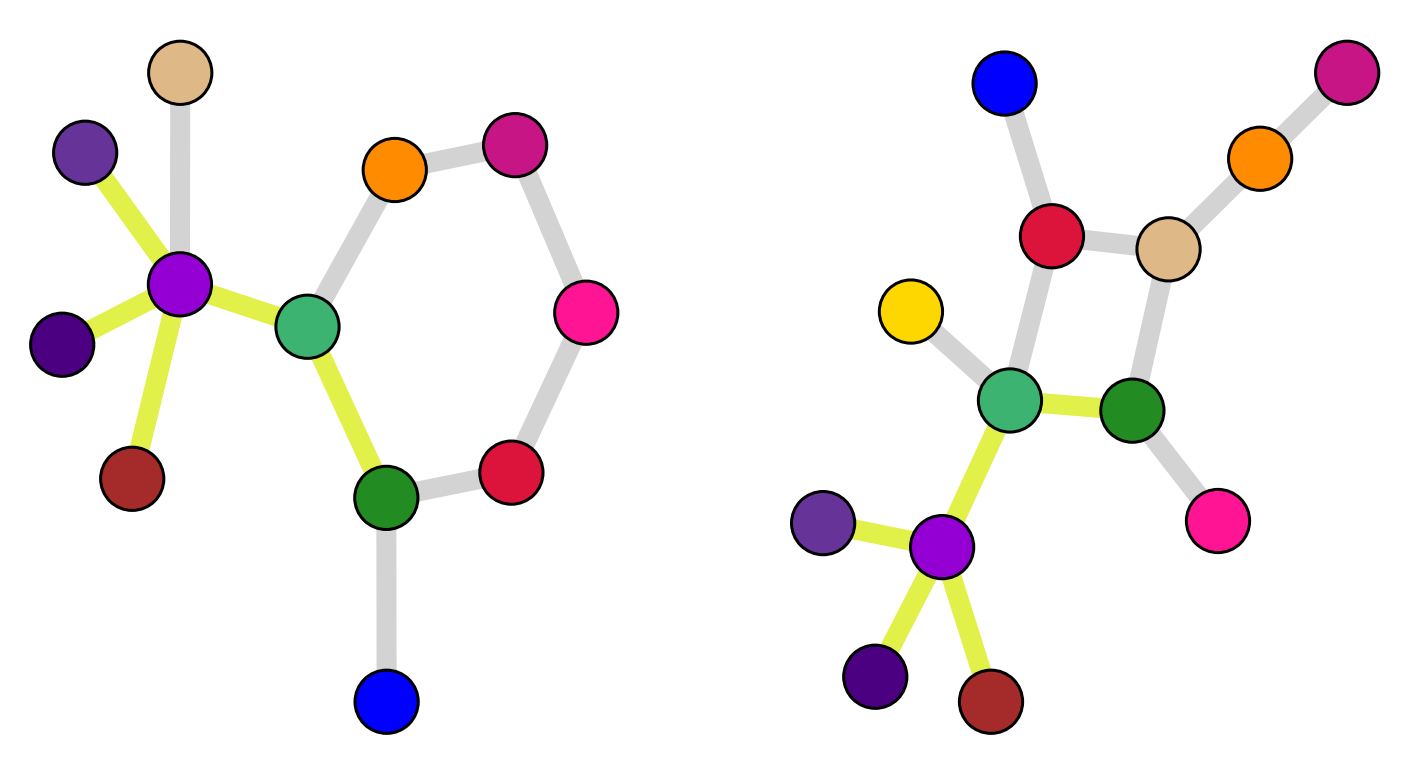

In [24]:
data_pair = test_data.list_all_gossip_qap_mcs[3586]
q_G = test_data.query_graphs[data_pair[0][0]]
c_G = test_data.corpus_graphs[data_pair[0][1]]
bestM1.diagnostic_mode = True
alignment = bestM1(*fetch_data(test_data1,[data_pair]))
row_ind, col_ind = scipy.optimize.linear_sum_assignment(-alignment.squeeze().detach().cpu())
plot_gossip_gr(test_data1, data_pair,col_ind,"lmccs_bad_fr.pdf")

In [25]:
align_result_dict = pickle.load(open("./Datasets/align_result_dict.pkl","rb"))